In [1]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from fbprophet import Prophet

from helpers import ecdf
from helpers import draw_bs_reps
from helpers import draw_bs_pairs_linreg

plt.style.use('ggplot')

In [2]:
# Import all necessary files
kids_df = pd.read_csv(r'Gapminder_data/kids_per_woman.csv', index_col=0)
kids_df.index.name = ''

life_exp_df = pd.read_csv(r'Gapminder_data/life_expectancy_years.csv', index_col=0)
life_exp_df.index.name = ''

ch_mort_df = pd.read_csv(r'Gapminder_data/child_mortality_0_5.csv', index_col=0)
ch_mort_df.index.name = ''

inc_df = pd.read_csv(r'Gapminder_data/income_per_person.csv', index_col=0)
inc_df.index.name = ''

pop_df = pd.read_csv(r'Gapminder_data/population_total.csv', index_col=0)
pop_df.index.name = ''

regions = pd.read_csv(r'Gapminder_data/regions.csv')
print(regions.head())

       country  region         income_group
0  Afghanistan    Asia           low_income
1      Albania  Europe  upper_middle_income
2      Algeria  Africa  upper_middle_income
3      Andorra  Europe          high_income
4       Angola  Africa  lower_middle_income


In [3]:
# Transpose dataframes
kids_transp = kids_df.transpose()
kids_transp['kids_avg'] = kids_transp.mean(axis=1, skipna=True)

life_exp_df_transp = life_exp_df.transpose()
life_exp_df_transp['life_exp_avg'] = life_exp_df_transp.mean(axis=1, skipna=True)

ch_mort_transp = ch_mort_df.transpose()
ch_mort_transp['ch_mort_avg'] = ch_mort_transp.mean(axis=1, skipna=True)

inc_df_transp = inc_df.transpose()
inc_df_transp['income_avg'] = inc_df_transp.mean(axis=1, skipna=True)

pop_transp = pop_df.transpose()
pop_transp['population_total'] = pop_transp.sum(axis=1, skipna=True)

In [4]:
# Merge all dataframes to create single with only mean values
df_merged_avg = pd.merge(kids_transp[['kids_avg']],
                         life_exp_df_transp[['life_exp_avg']], 
                         on=kids_transp.index, 
                         how='left', 
                         left_index=True, 
                         right_index=True)

df_merged_avg = df_merged_avg.join(ch_mort_transp['ch_mort_avg'], 
                                   on=df_merged_avg.index, 
                                   how='left')

df_merged_avg = df_merged_avg.join(inc_df_transp['income_avg'], 
                                   on=df_merged_avg.index, 
                                   how='left')

df_merged_avg = df_merged_avg.join(pop_transp['population_total'],
                                   on=df_merged_avg.index, 
                                   how='left')

df_merged_avg.index = pd.to_datetime(df_merged_avg.index, format='%Y')
df_merged_avg.head(2)

,kids_avg,life_exp_avg,ch_mort_avg,income_avg,population_total
1800-01-01,6.110707,31.502717,424.543478,978.523316,982454635
1801-01-01,6.107663,31.461957,423.918478,978.948187,985895135


In [5]:
df_century = df_merged_avg.loc['1900':'2020', :]
df_century.head(1)

,kids_avg,life_exp_avg,ch_mort_avg,income_avg,population_total
1900-01-01,5.905978,33.61087,383.923913,1897.875648,1642992800


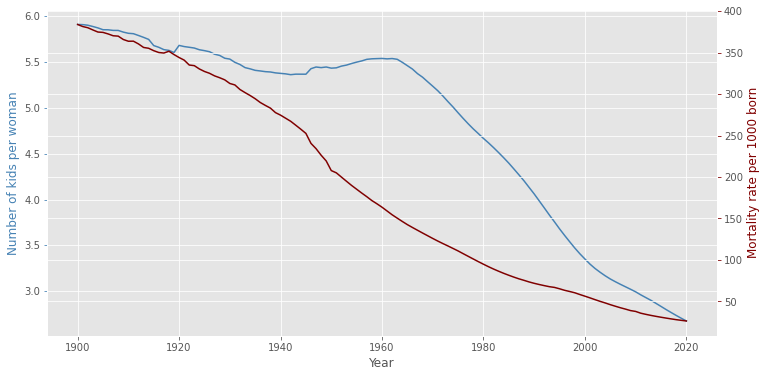

In [6]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df_century.index, df_century.kids_avg, color='steelblue')
ax.set_xlabel('Year')
ax.set_ylabel('Number of kids per woman', color='steelblue')
ax.tick_params('y', color='steelblue')

ax2 = ax.twinx()
ax2.plot(df_century.index, df_century.ch_mort_avg, color='maroon')
ax2.set_ylabel('Mortality rate per 1000 born', color='maroon')
ax2.tick_params('y', color='maroon')

plt.savefig(r'Charts/kids_mort_trends_century.jpg')
plt.show()

In [7]:
df_century.head(1)

,kids_avg,life_exp_avg,ch_mort_avg,income_avg,population_total
1900-01-01,5.905978,33.61087,383.923913,1897.875648,1642992800


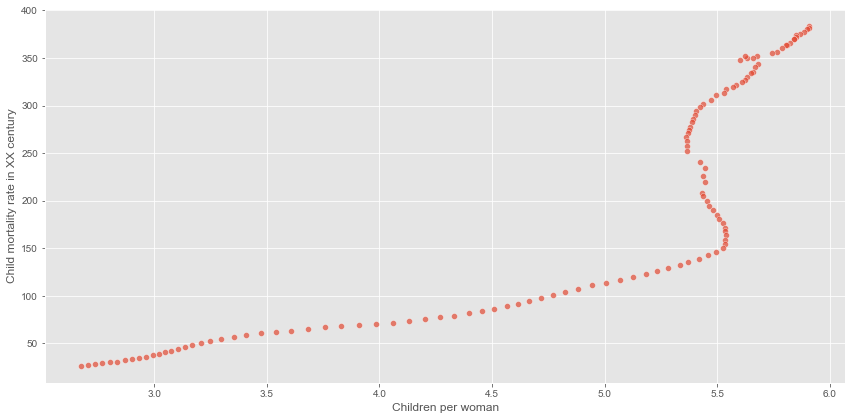

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set()

g = sns.scatterplot('kids_avg', 'ch_mort_avg', data=df_century, alpha=0.7, palette='muted')

plt.xlabel('Children per woman')
plt.ylabel('Child mortality rate in XX century')

plt.tight_layout()
plt.savefig('Charts/kids_life_exp_2020.jpg')

plt.show()

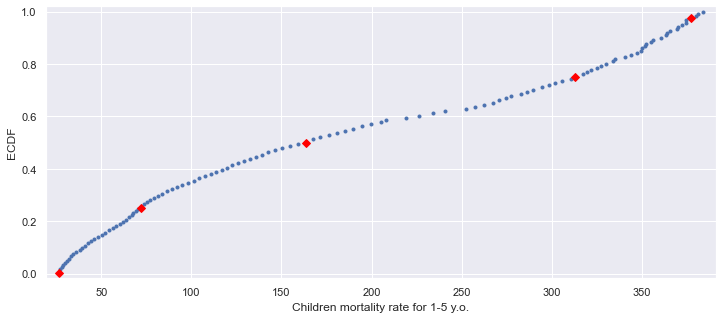

In [9]:
# ECDF plotting
fig, ax = plt.subplots(figsize=(12,5))

x, y = ecdf(df_century['ch_mort_avg'])

plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Children mortality rate for 1-5 y.o.')
plt.ylabel('ECDF')

percentiles = np.array([0.25, 25, 50, 75, 97.5])
perc_2020 = np.percentile(df_century.ch_mort_avg, percentiles)

# Overlay percentiles as red diamonds.
plt.plot(perc_2020, 
         percentiles/100, 
         marker='D', 
         color='red',
         linestyle='none')

# plt.savefig('Charts/ecdf_century.jpg')

plt.margins(0.02)
plt.show()

In [10]:
ch = df_century.ch_mort_avg.reset_index()
ch = ch['ch_mort_avg']
ch

0      383.923913
1      381.448370
2      380.005435
3      377.326087
4      374.801630
          ...    
116     29.930308
117     28.944359
118     28.010923
119     27.201846
120     26.438821
Name: ch_mort_avg, Length: 121, dtype: float64

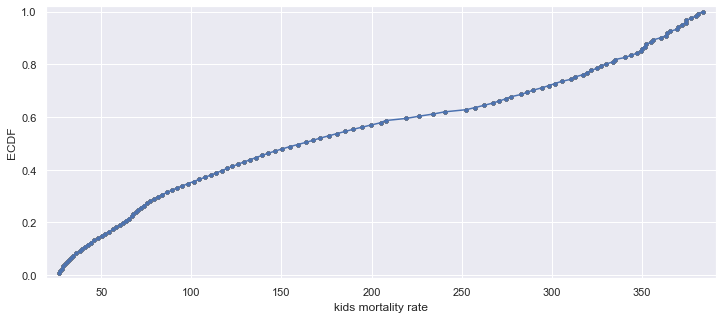

In [11]:
fig, ax = plt.subplots(figsize=(12,5))

for i in range(200):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(ch, size=len(ch))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(ch)
    plt.plot(x, y, 
             marker='.', 
             linestyle='none',
             color='gray', 
             alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(ch)
plt.plot(x, y, marker='.')

plt.margins(0.02)
plt.xlabel('kids mortality rate')
plt.ylabel('ECDF')

# Show the plot
plt.show()

In [12]:
df_century.head(1)

,kids_avg,life_exp_avg,ch_mort_avg,income_avg,population_total
1900-01-01,5.905978,33.61087,383.923913,1897.875648,1642992800


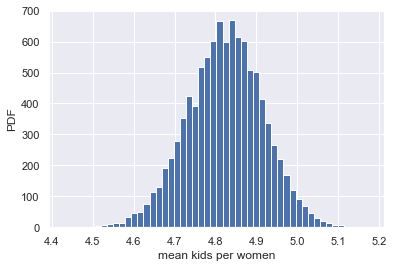

In [13]:
kids = df_century['kids_avg']
# Take 10,000 bootstrap replicates of the mean
bs_replicates = draw_bs_reps(kids, np.mean, 10000)

plt.hist(bs_replicates, bins=50)
plt.xlabel('mean kids per women')
plt.ylabel('PDF')

plt.show()

[ 91.75213886 110.06382388]


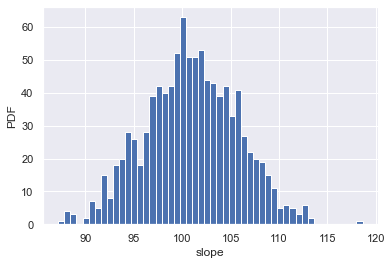

In [14]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps=draw_bs_pairs_linreg(df_century['kids_avg'], 
                                                      df_century['ch_mort_avg'], 
                                                      1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5,97.5]))

# Plot the histogram
plt.hist(bs_slope_reps, bins=50) #normed=True)

plt.xlabel('slope')
plt.ylabel('PDF')
plt.show()

95pct confidential interval [ 91.64900075 110.60052204]


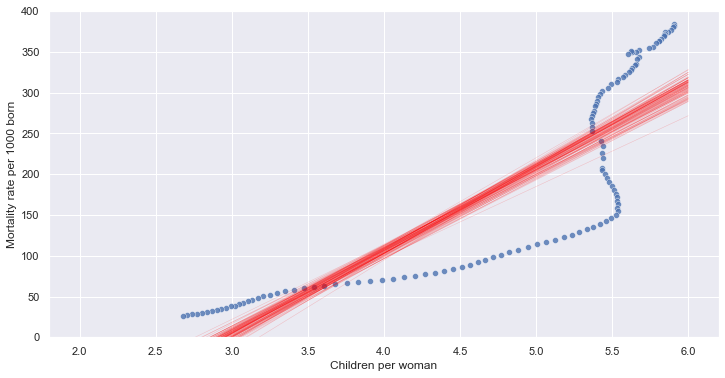

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

# Generate array of x-values for bootstrap lines: x
x = np.array([2,6])

# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(df_century.kids_avg, 
                                                        df_century.ch_mort_avg, 
                                                        1000)

# Compute and print 95% CI for slope
print('95pct confidential interval', np.percentile(bs_slope_reps, [2.5,97.5]))

y_2020 = sns.scatterplot(x='kids_avg', 
                         y='ch_mort_avg',
                         data=df_century,  
                         alpha=0.8)

plt.xlabel('Children per woman')
plt.ylabel('Mortality rate per 1000 born')
plt.ylim([0,400])

# # Plot the bootstrap lines
for i in range(100):
    plt.plot(x, 
             bs_slope_reps[i]*x + bs_intercept_reps[i],
             linewidth=0.5, 
             alpha=0.2, 
             color='red')

plt.show()

# FORECAST

In [16]:
df_century = df_century.reset_index()
df_century.head(2)

,index,kids_avg,life_exp_avg,ch_mort_avg,income_avg,population_total
0,1900-01-01,5.905978,33.610870,383.923913,1897.875648,1642992800
1,1901-01-01,5.904348,33.804348,381.448370,1914.709845,1655520970


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


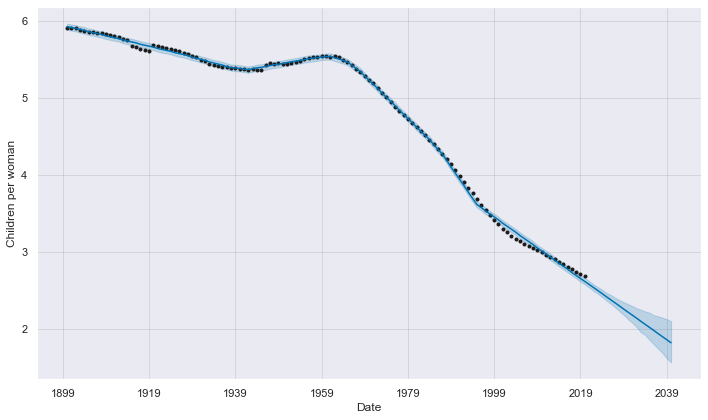

In [17]:
# Let's extract from dataframe only those fields we need for forecasting
fertility_prophet = df_century[['index','kids_avg']]
fertility_prophet=fertility_prophet.rename(columns={'index':'ds','kids_avg':'y'})

m=Prophet()
m.fit(fertility_prophet)
future=m.make_future_dataframe(periods=20, freq='Y')
forecast=m.predict(future)

figure1=m.plot(forecast,
               xlabel='Date',
               ylabel='Children per woman')

plt.tight_layout()

plt.savefig(r'Charts/forecast_fertility.jpg')

# figure=m.plot_components(forecast)

# With the Prophet algorithm we are able to forecast the fertility for the next years. We can see that the prediction is that the children number per woman will go down.